# Inversion for 1D Data

Here, we invert secondary magnetic field data for a single 1D FDEM sounding. We demonstrate 3 approaches for inverting the data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

## Load Data and Plot

In [3]:
# path to the directory containing our data
dir_path = "./1d_simulation_data/"

# Choose which side data to work with
side = "right" # "right" or "left"

if side == "left":
    data_filename = dir_path + "em1dfm_data_left.txt"
    true_layers = np.array([500.0])
    true_resistivities = np.r_[1000, 100]
elif side == "right":
    data_filename = dir_path + "em1dfm_data_right.txt"
    true_layers = np.array([1000.0, 1500.0])
    true_resistivities = np.r_[1000, 10, 100]
else:
    print("Invalid side chosen")

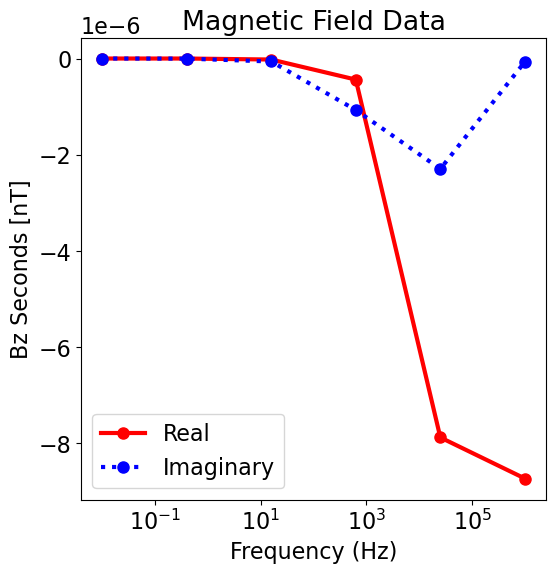

In [3]:
dobs = np.loadtxt(str(data_filename), skiprows=1)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs = mkvc(dobs[:, 1:].T)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9) *(dobs[0::2]), "r-o", lw=3)
ax.semilogx(frequencies, (10**9) *(dobs[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Seconds [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Defining the Survey

In [4]:
source_location = np.array([0.0, 0.0, 30.0])
moment = 1.0

receiver_location = np.array([10.0, 0.0, 30.0])
receiver_orientation = "z"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties

A percent uncertainty between 5% and 20% may be applied.

In [5]:
# 2% of the absolute value
uncertainties = 0.01 * np.abs(dobs) * np.ones(np.shape(dobs))

## Defining the Data

In [6]:
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

Here, we use the weighted least-squares inversion approach to recover the log-resistivity on a 1D layered Earth. We impose no a-priori information about the number of layers (geological units) or their thicknesses. Instead, we define a large number of layers with exponentially increasing thicknesses. And the depth, thickness and electrical properties of the Earth are inferred from the recovered model.

### Defining a 1D Layered Earth (1D Tensor Mesh)

First assuming we have a reasonable estimate of the regional coductivity ($\sigma$) within our are of interest, estimate maximum and minimum skin depth:

$$d \approx 500\sqrt{\frac{1}{\sigma f}} = 500\sqrt{\frac{\rho}{f}} $$

In [7]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 50000.0 m


In [8]:
depth_min = 10  # top layer thickness
depth_max = 6000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [9]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  45


### Model and Mapping to Layer Conductivities

In [10]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

### Define a Starting and/or Reference Model and the Mapping

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is log(0.1) S/m.

Define log-conductivity values for each layer since our model is the
log-conductivity. Don't make the values 0!
Otherwise the gradient for the 1st iteration is zero and the inversion will
not converge.



In [11]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

### Define the Physics using Simulation Object

In [12]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
)

### Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [13]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [14]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 45 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     45     -7,128.81         -0.00     10.00    602.40    1.10




In [15]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [18]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [19]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [20]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit]

In [21]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.85e+18  1.46e+22  0.00e+00  1.46e+22    9.85e+21      0              
   1  5.85e+18  1.45e+22  8.81e+00  1.46e+22    9.70e+21      0              
   2  5.85e+18  5.09e+21  6.19e+02  8.71e+21    9.50e+20      0   Skip BFGS  
   3  2.93e+18  5.85e+21  4.77e+02  7.25e+21    2.50e+21      0              
   4  2.93e+18  3.38e+21  1.12e+03  6.65e+21    5.74e+20      0              
   5  2.93e+18  3.96e+21  9.10e+02  6.62e+21    2.18e+20      0              
   6  1.46e+18  3.74e+21  9.83e+0

C:\Users\sabri\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


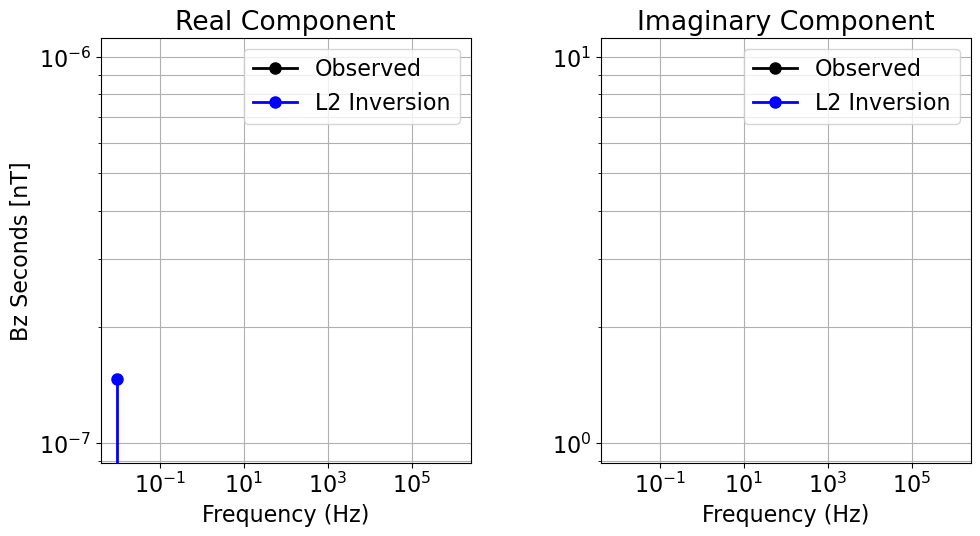

In [22]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].loglog(frequencies, (10**9) *(dobs[ii::2]), "k-o", lw=2)
    ax[ii].loglog(frequencies, (10**9) *(dpred_L2[ii::2]), "b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

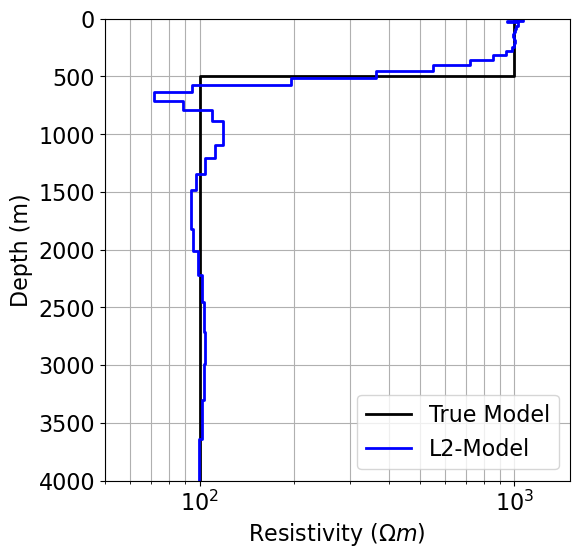

In [44]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()